# **Machine Learning 1**

## **PROJECT 1: Visualization and Data Preprocessing**

Randy Kim, Kati Schuerger, Will Sherman

### **BUSINESS UNDERSTANDING**

---

The **PlayerUnknown’s Battleground** (also known as PUBG) **Finish Placement Prediction** Kaggle competition was posted to "create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." This competition utilized publicly available official game data from PUBG through the PUBG Developer API. The questions of interest (QOI) were about the best strategy to win in PUBG, the best skillset, and to be able to model ranking in-game. The dataset provided was a breakdown of post-game metrics and percentile winning placement: with 4446966 records and 29 total features.

https://www.kaggle.com/c/pubg-finish-placement-prediction/data

We want to predict the two following things: winPlacePerc (continuous variable), and winPlaceQuartile (categorical variable). winPlacePerc is a ranking of a “players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place)." winPlaceQuartile is a new categorical variable we are adding to the dataset. This variable will have four categories, one for each quartile.

The first response, winPlacePerc, will require a regression model analyzing the mean-squared error (MSE) in combination with 10-fold cross-validation. Consequently, this was the same metric for the kaggle competition's QOI.

For the second response, winPlaceQuartile, we will measure accuracy in combination with 10-fold cross-validation.

Creating forecasting algorithms for online sports is not new. Therefore, the combination of the two measures could be related to optimizing a sports betting algorithms. You could also use these models for building and managing an effective team for tournaments. For example, the PUBG Global Championship 2021 Grand Finals had combined prize value of over 2 million USD.

In [ ]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from IPython.display import Image

from google.colab import files

In [ ]:
# create object for kaggle json file to use kaggle API (to load in data)
file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# make directory to store the data files 
!mkdir ~/.kaggle
# utilize kaggle.json
!cp kaggle.json ~/.kaggle/
# security settings so that individual user's credentials are passed in on local machine 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# load in the data files from kaggle website 
!kaggle competitions download -c pubg-finish-placement-prediction

100% 100M/100M [00:01<00:00, 104MB/s]  
100% 100M/100M [00:01<00:00, 91.2MB/s]
100% 17.0M/17.0M [00:00<00:00, 38.8MB/s]

 96% 235M/244M [00:02<00:00, 104MB/s] 
100% 244M/244M [00:02<00:00, 99.7MB/s]


In [ ]:
# unzip the data files
!unzip train_V2.csv.zip
!unzip test_V2.csv.zip

Archive:  train_V2.csv.zip
  inflating: train_V2.csv            
Archive:  test_V2.csv.zip
  inflating: test_V2.csv             


In [ ]:
pubg_raw = pd.read_csv("train_V2.csv")

In [ ]:
# when we are ready to build models - set seed for reproducability
np.random.seed(7)

In [ ]:
pubg_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

### **DATA TYPE MEANING**

The first three attributes (see above)—*Id*, *groupID*, and *matchID*—are alpha-numeric identifiers for the players, the teams/groups, and the individual matches that players participated in. These are stored as objects but could also be identified as strings.

The variables of type integer are *assists*, *boosts*, *DBNO*s, *headshotKills*, *heals*, *killPlace*, *killPoints*, *kills*, *killStreaks*, *matchDuration*, *maxPlace*, *numGroups*, *rankPoints*, *revives*, *roadKills*, *teamKills*, *vehicleDestroys*, *weaponsAcquired*, and *winPoints*.

·       DBNOs - Number of enemy players knocked. DBNO means “down but not out.” Essentially, “knocked” means to be knocked out. When a player is knocked, they lose their ability to shoot, move quickly, and to hold a gun. Players do not die instantly when knocked, when playing in a group (on a team) - other members of the team can revive a knocked player. (do we need this last line?)

·       assists - Number of enemy players this player damaged that were killed by teammates.

·       boosts - Number of boost items used. Boost items are things that improve a player’s health, examples are energy drinks, painkillers, and adrenaline syringes.

·       damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.

·       headshotKills - Number of enemy players killed with headshots. 

·       heals - Number of healing items used.
·       Id - Player’s Id

·       killPlace - Ranking in match of number of enemy players killed.

·       killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

·       killStreaks - Max number of enemy players killed in a short amount of time.

·       kills - Number of enemy players killed.

·       longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

·       matchDuration - Duration of match in seconds.

·       matchId - ID to identify match. There are no matches that are in both the training and testing set.

·       matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

·       rankPoints - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

·       revives - Number of times this player revived teammates.

·       rideDistance - Total distance traveled in vehicles measured in meters.

·       roadKills - Number of kills while in a vehicle.
·       swimDistance - Total distance traveled by swimming measured in meters.

·       teamKills - Number of times this player killed a teammate.

·       vehicleDestroys - Number of vehicles destroyed.

·       walkDistance - Total distance traveled on foot measured in meters.

·       weaponsAcquired - Number of weapons picked up.

·       winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.

·       groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

·       numGroups - Number of groups we have data for in the match.

·       maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

·       winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match. (Higher is better.)

*Definitions pulled from Kaggle*: https://www.kaggle.com/c/pubg-finish-placement-prediction/data

*Additional details added to elaborate on/clarify some of the variables.*

In [ ]:
# df = pubg_raw.drop(columns = ["Id", "groupId", "matchId"], axis = 1)
df = pubg_raw
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
dfDup = df.drop_duplicates(subset = ["groupId"])
print(dfDup.groupby("matchType")["Id"].nunique())
print("             ")
print("Number of distinct " + "\033[1m" + "matchType" + "\x1B[0m" + " is {}".format(dfDup.groupby("matchType")["Id"].nunique().count()))

matchType
crashfpp              3130
crashtpp               180
duo                 152324
duo-fpp             486491
flarefpp               200
flaretpp               695
normal-duo             101
normal-duo-fpp        2815
normal-solo            232
normal-solo-fpp       1227
normal-squad           124
normal-squad-fpp      3950
solo                168577
solo-fpp            523458
squad               177080
squad-fpp           506161
Name: Id, dtype: int64
             
Number of distinct matchType is 16


If we were to one-hot encode the *matchType* feature, we'd need to include 16 additional columns for the categories contained in *matchType*.

### **DATA QUALITY**

As presented in the following code snippet, our dataset appears dense rather than sparse. There is only one missing value and it is in our first response variable (additional detail for the NA provided below).



In [ ]:
# check for misssing values
colname = list(pubg_raw.columns)

for i in range(len(pubg_raw.columns)):
  count = pubg_raw[pubg_raw.columns[i]].isna().sum()
  print("Column '{col}' has {ct} NAs".format(col = colname[i], ct = count))

Column 'Id' has 0 NAs
Column 'groupId' has 0 NAs
Column 'matchId' has 0 NAs
Column 'assists' has 0 NAs
Column 'boosts' has 0 NAs
Column 'damageDealt' has 0 NAs
Column 'DBNOs' has 0 NAs
Column 'headshotKills' has 0 NAs
Column 'heals' has 0 NAs
Column 'killPlace' has 0 NAs
Column 'killPoints' has 0 NAs
Column 'kills' has 0 NAs
Column 'killStreaks' has 0 NAs
Column 'longestKill' has 0 NAs
Column 'matchDuration' has 0 NAs
Column 'matchType' has 0 NAs
Column 'maxPlace' has 0 NAs
Column 'numGroups' has 0 NAs
Column 'rankPoints' has 0 NAs
Column 'revives' has 0 NAs
Column 'rideDistance' has 0 NAs
Column 'roadKills' has 0 NAs
Column 'swimDistance' has 0 NAs
Column 'teamKills' has 0 NAs
Column 'vehicleDestroys' has 0 NAs
Column 'walkDistance' has 0 NAs
Column 'weaponsAcquired' has 0 NAs
Column 'winPoints' has 0 NAs
Column 'winPlacePerc' has 1 NAs


In [ ]:
pubg_raw[pubg_raw.isna().any(axis = 1)]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,0,0,0,0.0,9,solo-fpp,1,1,1574,0,0.0,0,0.0,0,0,0.0,0,0,NaN


This particular *NA* response value appears to be due to a solo-fpp match (solo first person shooter) without any competitors. This evaluation is supported by the match only lasting 9 seconds (under *matchDuration*) and *numGroups* having a value of 1.

Because this cannot produce an appropriate evaluation metric for determining win place percentage, we will proceed to drop this record.

In [ ]:
pubg_raw = pubg_raw.dropna()
pubg_raw.isnull().values.any()

False

In [ ]:
pubg_raw.duplicated().any()

False

The above code snippet is checking for duplicate rows. While there may be duplicate data for *Id*, *groupId*, *matchId*, or other variables, there are no truly duplicated rows.

#### **Evaluating Data Shape**

Much of the data appears to be right-skewed. This may impact our ability to run analytics unless we normalize and/or standardize our data.

There are a few notable exceptions: *matchDuration*, *maxPlace*, and *numGroups*. These appear to be either bimodal or trimodal with *matchDuration* being fairly centered on the mean but *maxPlace* and *numGroups* again exhibiting right-skew.

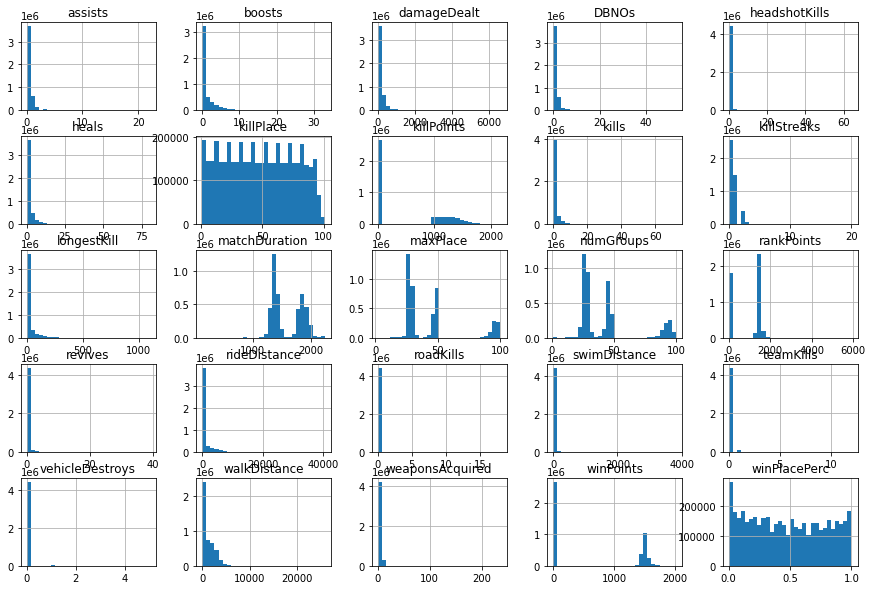

In [ ]:
in_plot = pubg_raw.hist(bins=30, figsize = (15, 10))[2]

CHECKING FOR OUTLIERS - POTENTIAL CHEATING

One of the possible explanations for outliers in the data could be cheating. We took a look at a couple of attributes in the data that might indicate less-than-honest players. (Perhaps these players are just super good at the game, either way, they would not be the best example of typical players, and their data might negatively impact the performance of our models.)

In [ ]:
# CHECKING FOR OUTLIERS = headshotKills
# there are a few records that could be misleading due to cheating

pubg_raw.loc[:,'headshotKills'].value_counts()
## recommend removing records with >10 headshotKills

0     3696115
1      574741
2      126348
3       32975
4        9962
5        3616
6        1439
7         757
8         373
9         215
10        136
11         79
12         64
13         44
14         23
15         16
16         15
17         11
18          9
19          3
23          3
20          3
26          3
31          2
34          2
27          2
21          2
41          1
64          1
40          1
39          1
46          1
42          1
35          1
Name: headshotKills, dtype: int64

In [ ]:
# Potential Cheating
pntlCheating = pubg_raw[["walkDistance", "headshotKills", "winPlacePerc", "matchType"]]
pntlCheating[(pntlCheating["walkDistance"] < 500) & 
             (pntlCheating["winPlacePerc"] >= 0.65) & 
             (pntlCheating["headshotKills"] > 10)].sort_values(by = "walkDistance", ascending = True)

,walkDistance,headshotKills,winPlacePerc,matchType
954479,0.000,16,1.0000,normal-squad-fpp
1893305,0.000,11,0.6667,normal-solo-fpp
1452615,0.000,12,1.0000,normal-solo-fpp
425984,0.000,18,1.0000,normal-squad-fpp
3701105,0.000,12,1.0000,normal-solo
3057746,0.000,18,0.7500,normal-squad-fpp
1702541,0.000,11,1.0000,normal-squad-fpp
1368181,0.000,13,0.7222,normal-solo-fpp
1955074,0.000,16,1.0000,normal-squad-fpp
2998470,0.000,26,1.0000,normal-solo-fpp


### **SIMPLE STATISTICS**

Because most of our data is continuous (either integers or floats), a large amount of our data can be evaluated for simple statistical measures.

In [ ]:
stats = pubg_raw.describe()
stats

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.307172e+02,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,2.299760e+01,1.579507e+03,4.450468e+01,4.300760e+01,8.920103e+02,1.646590e-01,6.061158e+02,3.496092e-03,4.509323e+00,2.386841e-02,7.918209e-03,1.154218e+03,3.660488e+00,6.064603e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587388e+02,2.382810e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261158e-02,1.183497e+03,2.456543e+00,7.397005e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.330000e+02,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


The majority of our data are integers (19), 6 are floats, and 4 are objects. 
The standard deviation is pretty small for all numeric attributes (all are less than 1,498). 

In [ ]:
stats.apply(pd.DataFrame.max, axis=1)

count    4.446965e+06
mean     1.579507e+03
std      1.498344e+03
min      1.330000e+02
25%      1.367000e+03
50%      1.443000e+03
75%      1.976000e+03
max      4.071000e+04
dtype: float64

The simple statistics that we pulled are meaningful because they tell us the shape of our data by attribute. One of the most useful measures is standard deviation, which tells us the spread of our data. The largest standard deviation is around 1,498, which tells us that we have some variables in our data with funky outliers or that operate on a scale much larger than other attributes. Further analysis may be beneficial to potentially standardize or normalize these variables. 

*Below code borrowed from*: https://www.kaggle.com/suyashpratapsingh/eda-on-pubg-dataset

In [ ]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less,\n while the most kills ever recorded is {}.".format(pubg_raw['kills'].mean(),pubg_raw['kills'].quantile(0.99), pubg_raw['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less,
 while the most kills ever recorded is 72.


This statistic tells us that we have about 1% of our data with abnormally high kills count. These may be the result of cheating, or maybe just a super-good player, but either way, they are an anomaly and not representative of your typical player.

### **VISUALIZE ATTRIBUTES**

Our first visualization can be seen above under "Evaluating Data Shape". One of the key issues with much of our data is the right-skew it exhibits.

One particular area of concern, however, is the headshotKills variable.

ATTRIBUTE 1: headshotKills

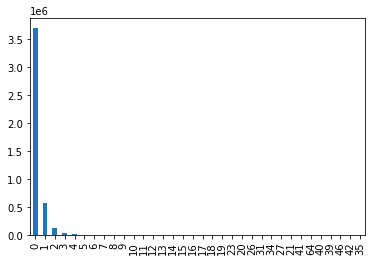

In [ ]:
# plot of headshotKills
ax = pubg_raw.loc[:,'headshotKills'].value_counts().plot(kind='bar')

The bar plot is the best representation to look into the distribution of headshotKills because it shows us the max value (64). A histogram would give us frequency counts by # of headshotKills, but would not show us the actual counts that we need to understand what the data looks like. 

The boxplot below gives another representation of the spread of the data, as we were not really able to see where high-headshot counts fall on the bar chart. Here we can see that this attribute is right-skewed and that we have a couple outliers with much higher counts. 

The max number of headshot kills is 64


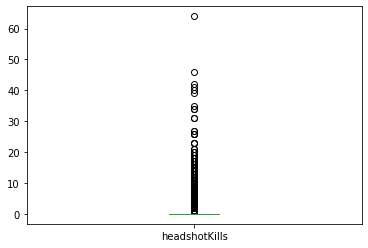

In [ ]:
pubg_raw.loc[:, 'headshotKills'].plot(kind='box')
print("The max number of headshot kills is {}".format(pubg_raw.loc[:, 'headshotKills'].max()))

**More than 10 headshotKills**: The headshotKills variable is heavily right skewed; the majority of players make fewer than 10 kills this way, but there are a handful of records (424 out of 4,446,966 total records, or 0.01%) with 10 headshotKills or more.

ATTRIBUTE 2: winPlacePerc

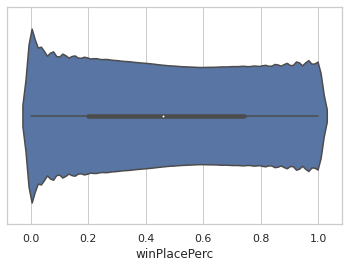

In [ ]:
sns.set_theme(style="whitegrid")
wpp = sns.violinplot(x=pubg_raw.loc[:,'winPlacePerc'])

Our first response variable of interest has a fairly uniform distribution. Because there is slightly more weight at the low end than the high end of *winPlacePerc*, we shouldn't need to do any posthoc analysis with regard to variable weighting.

A violin plot is a better visualization than a boxplot since a boxplot can oversimplify the underlying shape of the data. The violinplot here, accurately portrays the feature's shape.

ATTRIBUTE 3: killPlace

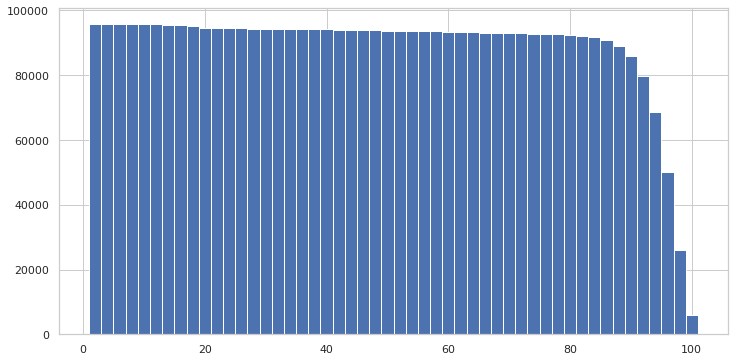

In [ ]:
kp = pubg_raw.loc[:,'killPlace'].hist(bins=50, figsize = (12, 6))

The *killPlace* predictor is closer to the distribution of the winPlacePerc variable. This is one of the few continuous variables which does not have extreme right-skew.

The fact that *killPlace* has a semi-similar distribution to *winPlacePerc* makes it a variable of interest for correlation analysis.

The boxplot turned out a little cleaner than the violinplot for this particular feature.

ATTRIBUTE 4: weaponsAcquired

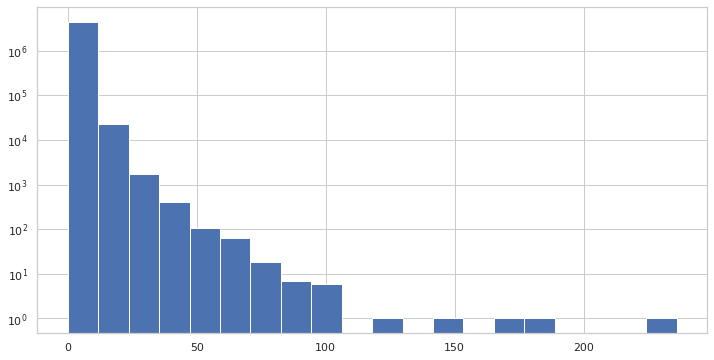

In [ ]:
## weapons acquired
wa = pubg_raw.loc[:,'weaponsAcquired']

plt.yscale('log', nonposy='clip') # Utilized https://matplotlib.org/2.0.2/api/pyplot_api.html for code
log_wa = wa.hist(bins=20, figsize = (12, 6))

The *weaponsAcquired* variable does have recognizable right-skew. This is another of the variables of interest which we'll see in the **explore joint attributes** section.

This visualization is more appropriate in the log-scale so that we can actually visualize the instances of weapons acquired for the skewed portion of the data.

ATTRIBUTE 5: winPoints 

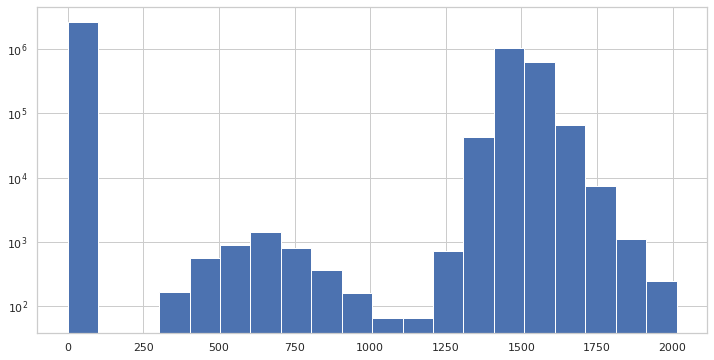

In [ ]:
## winPoints
wp = pubg_raw.loc[:,'winPoints']

plt.yscale('log', nonposy='clip')
log_wp = wp.hist(bins=20, figsize = (12, 6))

This graphic is actually very informative compared to the general histogram provided in the "evaluating data shape" section. Under that analysis, we might have viewed *winPoints* as a bimodal data with centers at 0 and approximately 1500. However, this visualization shows that there may be an additional modality in the data. This visualization is appropriate to show the shape of this feature in order to provide additional insight.

## **EXPLORE JOINT ATTRIBUTES**

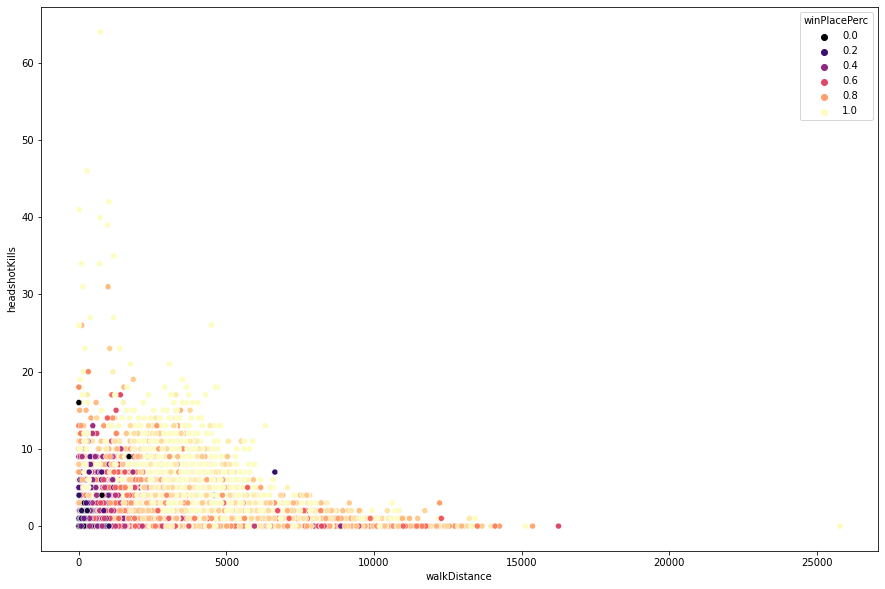

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = pubg_raw, x="walkDistance", y="headshotKills",
                hue="winPlacePerc", sizes=(20, 200), palette="magma")
plt.show()

Walk distance had the highest correlation with our variable-of-interest: win place percentage.

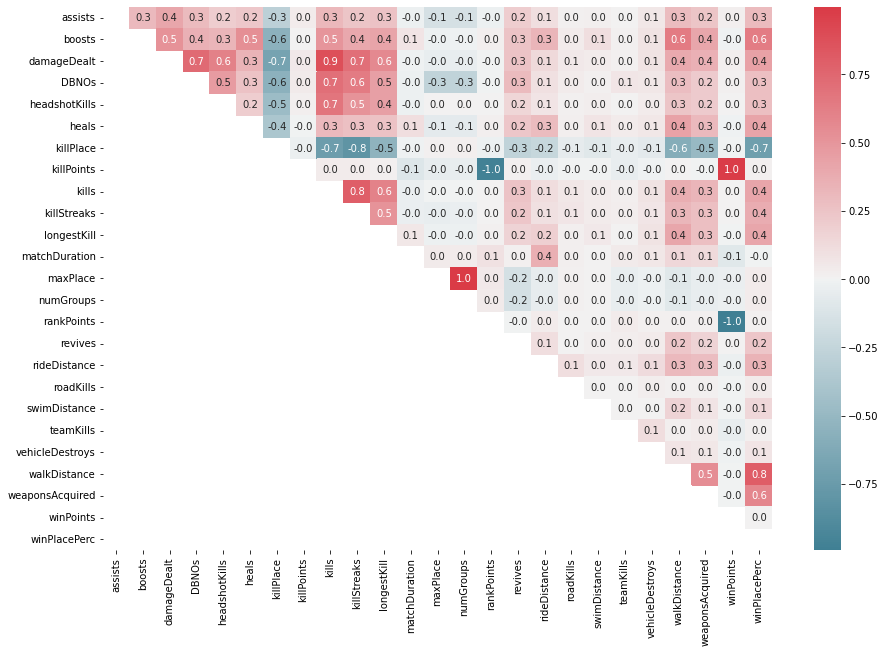

In [ ]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize = (15, 10))
corrMatrix = pubg_raw.corr()
sns.heatmap(corrMatrix, ax=ax, annot=True, fmt=".1f", cmap=cmap,
            mask=np.tril(np.ones_like(corrMatrix, dtype=bool)))

Correlation with winPlacePerc:
1. There is strong correlation between winPlacePerc and weaponsAcquired, winPoints, and boosts. A positive correlation means that an increase in each of these attributes is associated with an increase in winPlacePerc (the relationship is not 1 to 1, each has a different strength of the relationship).
2. A strong negative correlation exists between winPlacePerc and killPlace. This tells us that a low killPlace (lower is better) is associated with a high winPlacePerc (higher is better), which makes sense, a player with a better killPlace would rank better in the winPlace. 

The strong correlation between these attributes and the target variable (winPlacePerc) tells us that these are likely the ones that have the most influence on the winPlacePerc attribute, and should be included in our final model. 

Additional observations (related to the attributes strongly correlated with winPlacePerc target variable: weaponsAcquired, winPoints, boosts, and killPlace):
1. The weaponsAcquired feature does not appear to have a high correlation with any other attributes.
2. There's a strong correlation between winPoints and killPoints.
3. A strong correlation exists between boosts and walkDistance and a strong negative correlation between boosts and killPlace.
4. Another strong negative correlation can be found between killPoints and kills, killStreaks, and walkDistance.

Additional observations (misc):
1. We find high negative correlation between rankPoints and killPoints.
2. There's high negative correlation between rankPoints and winPoints. 

In [ ]:
c = df.corr()["winPoints"].abs()
round(c.sort_values(ascending = False).head(7), 4)

winPoints        1.0000
MMR              0.9965
rankPoints       0.9938
killPoints       0.9834
matchDuration    0.0874
teamKills        0.0409
maxPlace         0.0293
Name: winPoints, dtype: float64

In [ ]:
s = df.corr()["winPlacePerc"].abs()
round(s.sort_values(ascending = False).head(10), 4)

winPlacePerc       1.0000
walkDistance       0.8109
killPlace          0.7191
totalItems         0.6862
totalDistance      0.6770
boosts             0.6342
weaponsAcquired    0.5838
healItems          0.5760
killsAssist        0.4531
damageDealt        0.4405
Name: winPlacePerc, dtype: float64

In [ ]:
k = df.corr()["killPoints"].abs()
round(k.sort_values(ascending = False).head(7), 4)

killPoints       1.0000
MMR              0.9951
winPoints        0.9834
rankPoints       0.9756
matchDuration    0.0995
damageDealt      0.0499
maxPlace         0.0448
Name: killPoints, dtype: float64

## **NEW FEATURES**



In [ ]:
df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
df['killsAssist'] = df['kills'] + df['assists']
df['totalItems'] = df['heals'] + df['boosts'] + df['weaponsAcquired']
df['healItems'] = df['heals'] + df['boosts']
df['MMR'] = df['killPoints'] + df['winPoints'] # + df['rankPoints'] <- may take out rank points as it depends on killPoints & winPoints

The feature changes that may benefit our analysis are varied. One approach is to change player's movement from separate distance metrics to a single overal metric.

Positive associations for *kills* and *assists* with our response may be described together. This combined variable would represent "shots on opponents" that led to kills.

Item acquisition in PUBG may show  more savvy players because many items are more difficult to find.

In [ ]:
df.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalDistance,killsAssist,totalItems,healItems,MMR
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01,1.764843e+03,1.158598e+00,6.137543e+00,2.477055e+00,1.111466e+03
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01,2.183117e+03,1.833479e+00,5.346595e+00,3.879985e+00,1.361564e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01,1.581000e+02,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01,7.882000e+02,0.000000e+00,5.000000e+00,1.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01,2.728447e+03,2.000000e+00,9.000000e+00,4.000000e+00,2.659000e+03
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00,4.127010e+04,8.500000e+01,2.390000e+02,8.100000e+01,4.023000e+03


## **EXPLORE ATTRIBUTES & CLASS**

We continue our analysis of joint attributes with the transformed features and our response of interest:

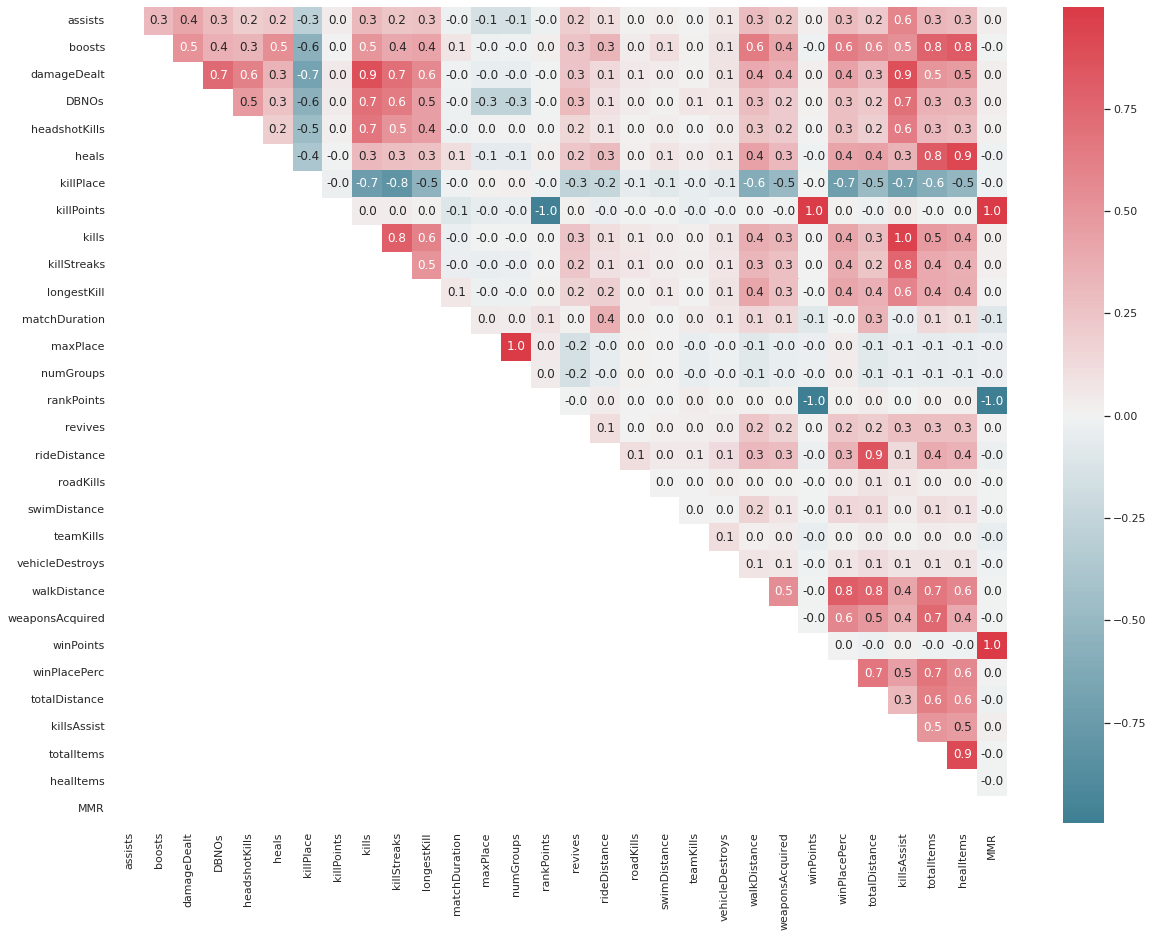

In [ ]:
fig_dims = (20, 15)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(df.corr(), 
            ax = ax, 
            annot = True, 
            fmt = ".1f", 
            cmap = cmap,
            mask = np.tril(np.ones_like(df.corr(), dtype = bool)))

plt.show()

In [ ]:
# Variables above 0.4 correlation with winPlacePerc
## note: we are using absolute value: correlations >0.4 and <-0.4 are included
s = df.corr()["winPlacePerc"].abs()
round(s.sort_values(ascending = False).head(10), 4)
feature = abs(df.corr()["winPlacePerc"][abs(df.corr()["winPlacePerc"]) > 0.4]).index.tolist()
feature

['boosts',
 'damageDealt',
 'heals',
 'killPlace',
 'kills',
 'longestKill',
 'walkDistance',
 'weaponsAcquired',
 'winPlacePerc',
 'totalDistance',
 'killsAssist',
 'totalItems',
 'healItems']

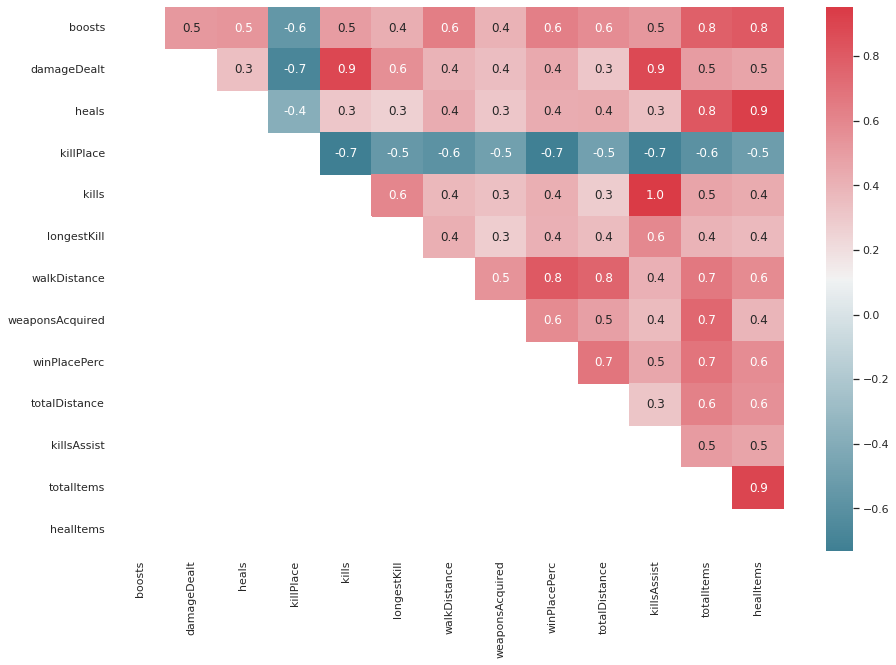

In [ ]:
fig_dims = (15, 10)
fig, ax = plt.subplots(figsize = fig_dims)
sns.heatmap(df[feature].corr(), 
            ax = ax, 
            annot = True, 
            fmt = ".1f", 
            cmap = cmap,
            mask = np.tril(np.ones_like(df[feature].corr(), dtype = bool)))

plt.show()

The figure above represents the variables with the highest correlation to our primary response variable: winPlacePerc. The cutoff of correlation in this visualization is 0.3.

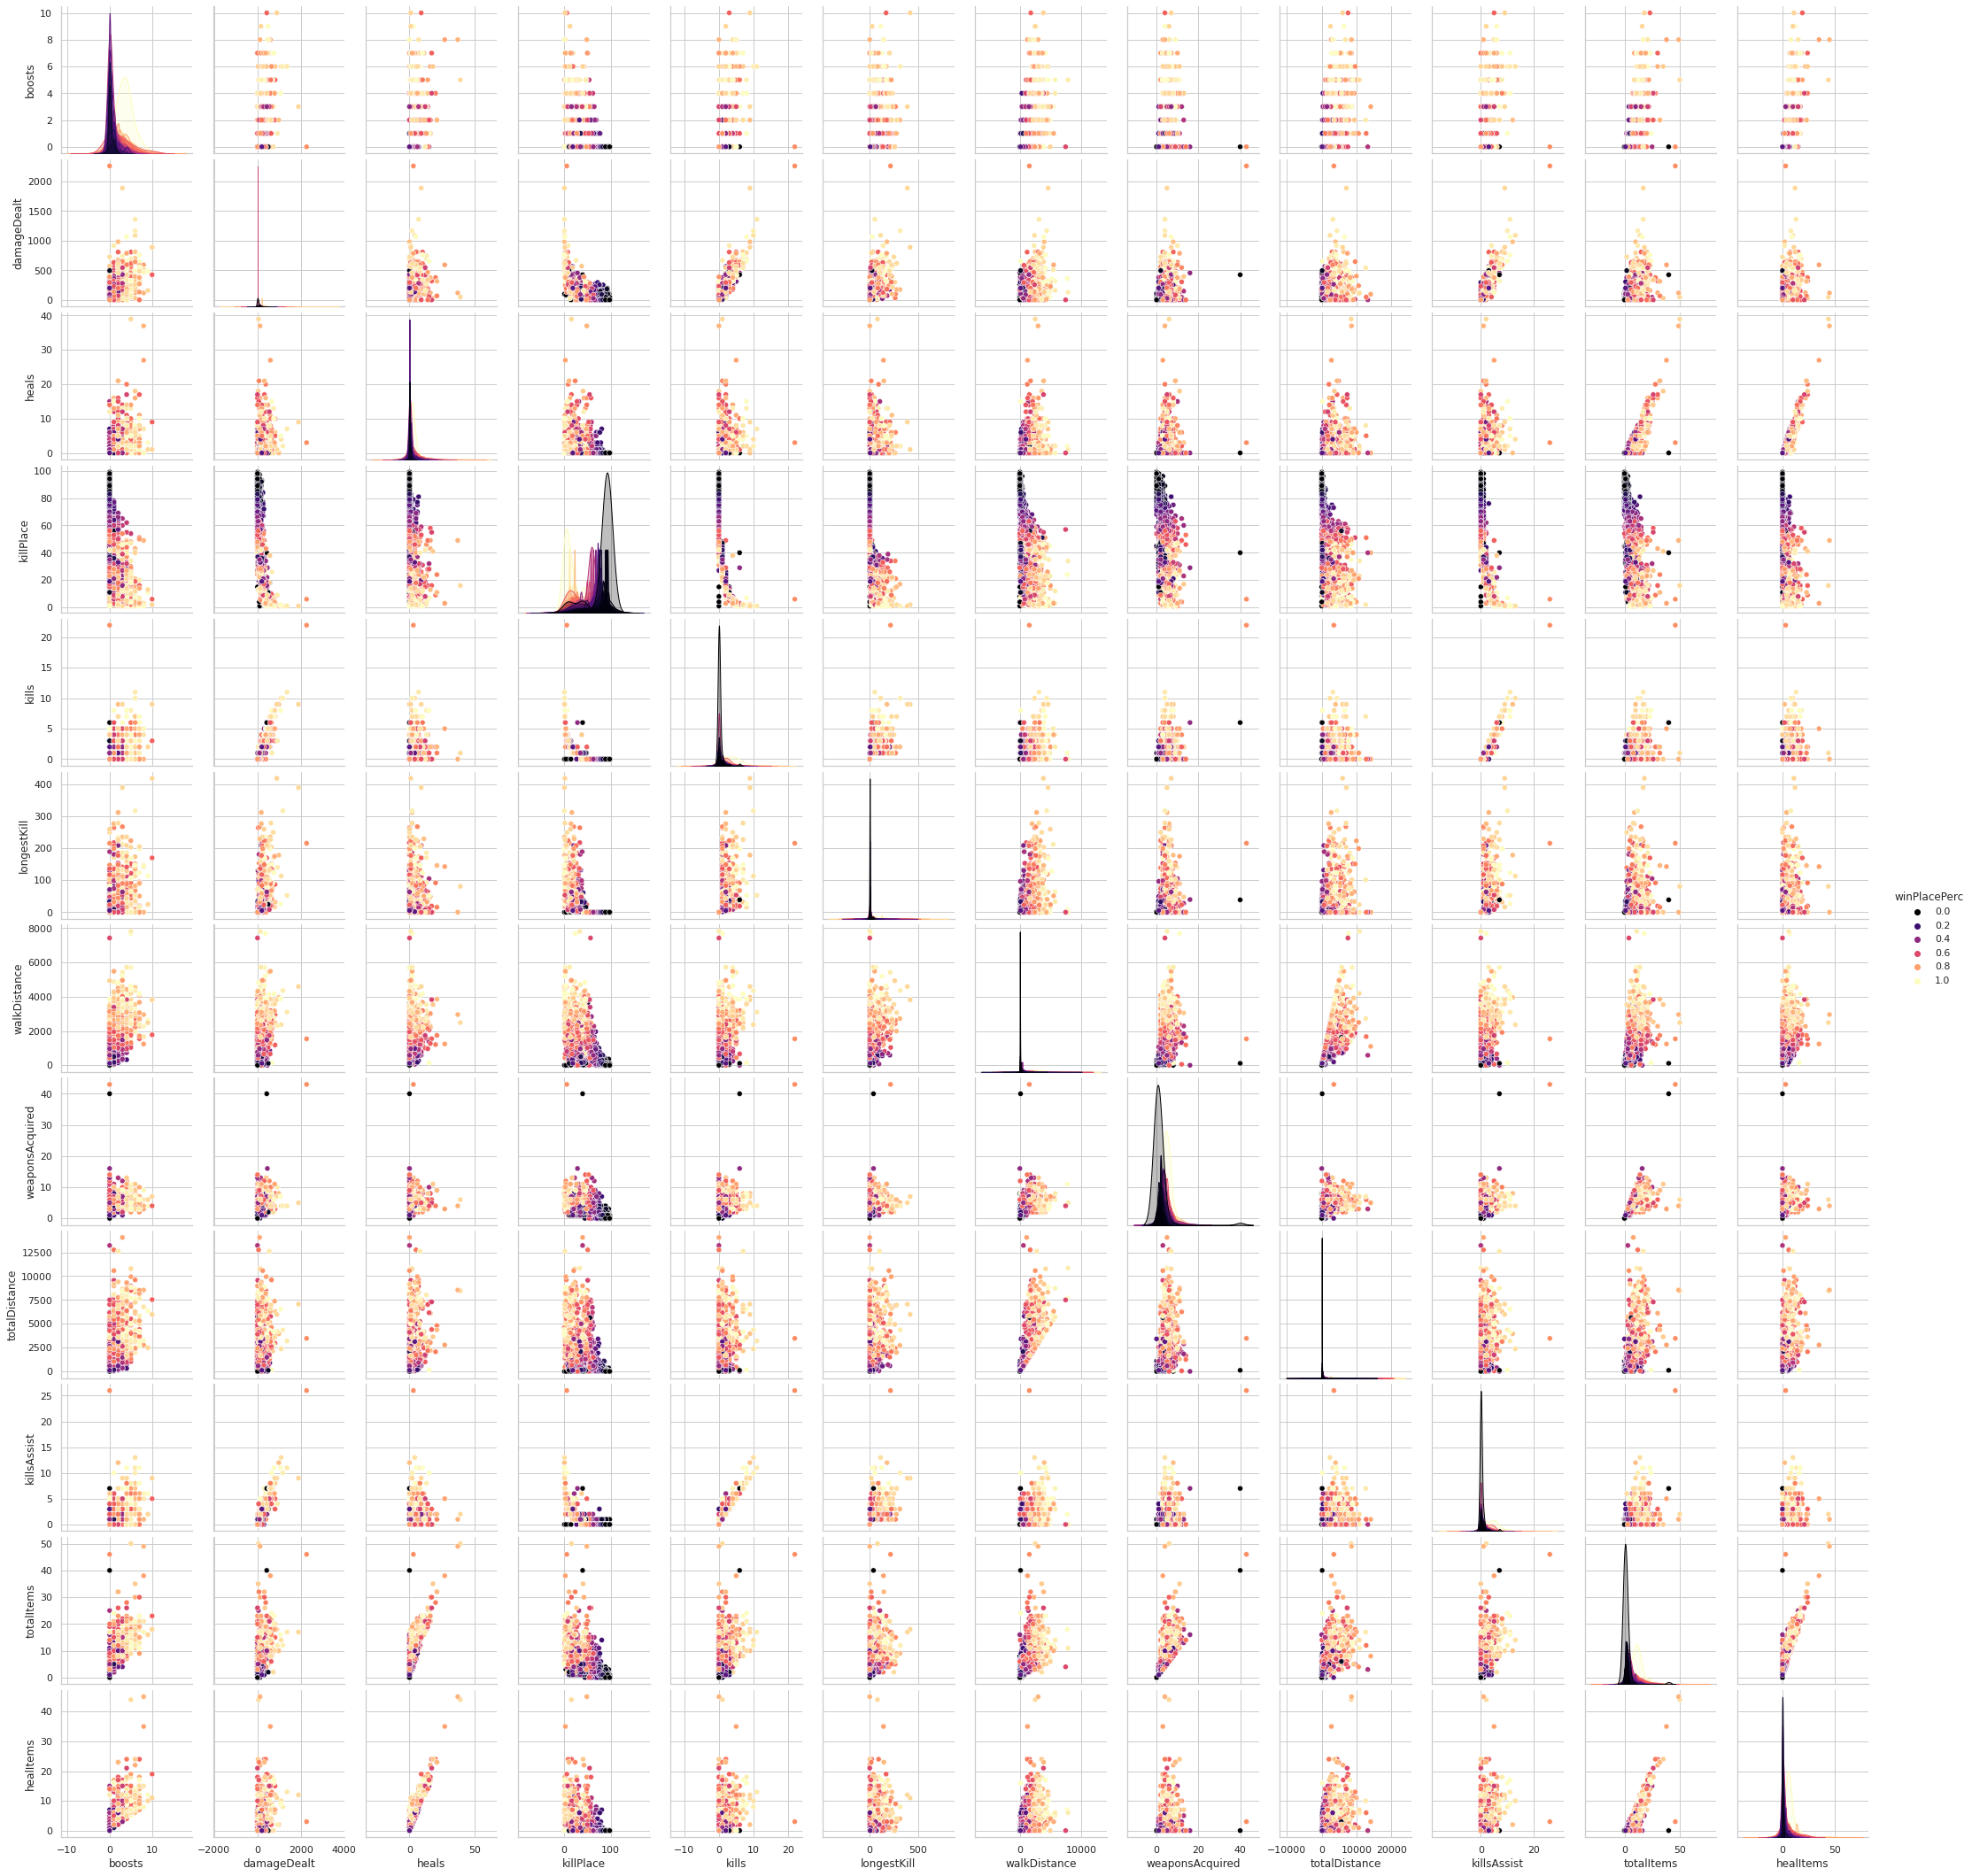

<Figure size 1080x720 with 0 Axes>

<Figure size 2246.93x2160 with 0 Axes>

In [ ]:
plt.figure(figsize = (15, 10))
pairOne = sns.pairplot(df[feature].sample(1500), 
             hue = "winPlacePerc",
             palette = "magma")
pairOne.savefig("pairOne.png")

plt.clf()
Image(filename = "pairOne.png")

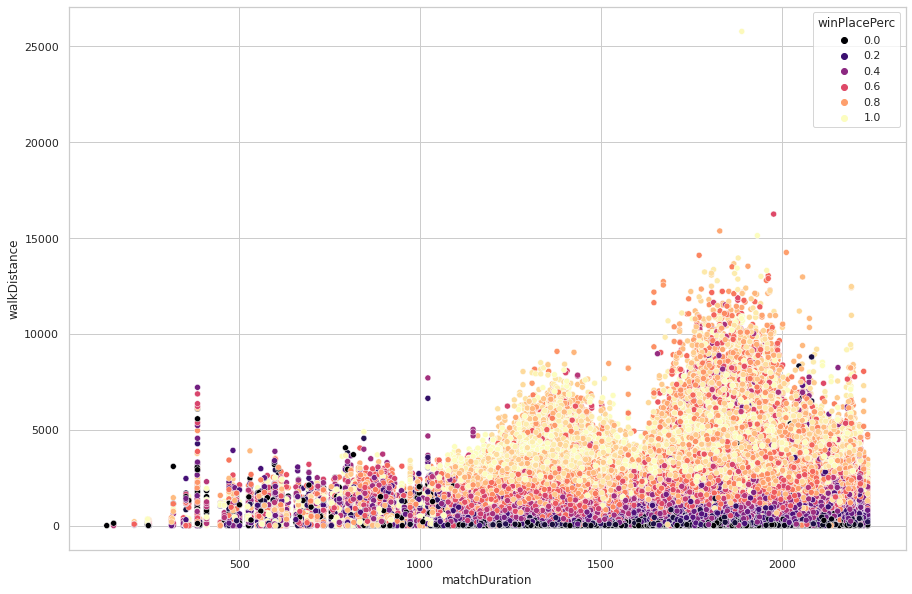

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df, x = "matchDuration", y = "walkDistance", hue = "winPlacePerc", sizes = (20, 200), palette = "magma")
plt.show()

Generally speaking, as matchDuration increases, the variability of walkDistance increases. This registers logically: the longer a game goes on, the farther many players will travel to find opponents or in combat.

Additionally, with the color-distribution we can see some of how walkDistance is positively correlated with winPlacePerc.

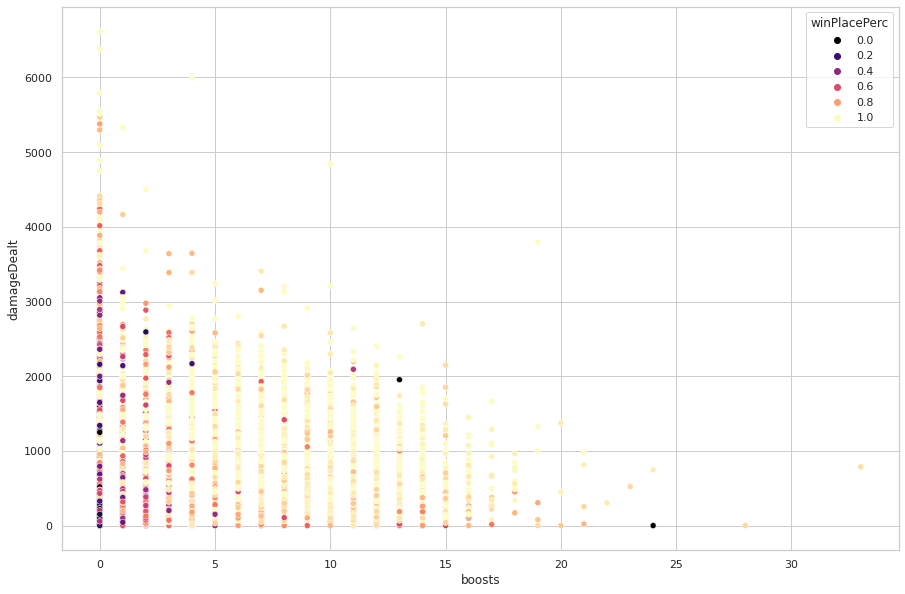

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df, x = "boosts", y = "damageDealt", hue = "winPlacePerc", palette = "magma")
plt.show()

# results look as expected - more damageDelt goes with lower winPlacePerc 
# lower is better for winPlacePerc 

This visualization shows how the positive correlation between boosts and winPlacePerc. It also shows that players who have few boosts and deal little damage tend to have lower winPlacePerc outcomes.

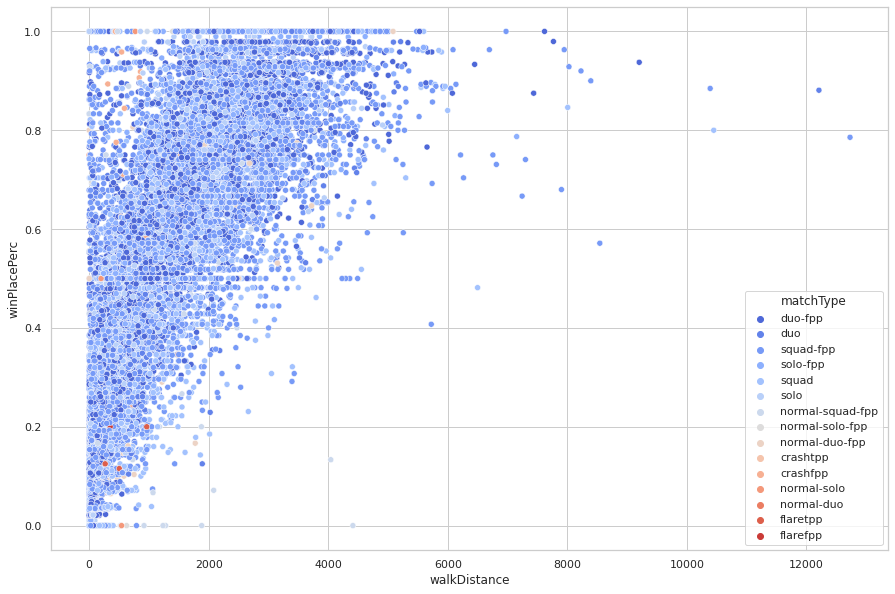

In [ ]:
# Overwhleming numbers of Rank Mode Games compare to other Game Mode.
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df.sample(20000), x = "walkDistance", y = "winPlacePerc", 
                hue = "matchType",
                palette = "coolwarm")
plt.show()

Our analysis on matchType here shows a lack of trend in determining winPlacePerc. We utilized walkDistance as an additional comparative feature due to the high correlation with winPlacePerc.

In [ ]:
def matchType(df):

    options = ["all", "event", "nonevent", "rank", "normal", "include", "exclude", "fpp", "tpp"]

    while True:
        print("Game Mode options are All, Event, NonEvent, Rank, Normal")
        print("--------------------------------------------------------")
        E = str(input("Game Mode: ")).lower()
        if E in options:
            break

    if E == "all":
        output = df
    elif E == "event":
        output = df.loc[df["matchType"].str.contains("crash|flare", case = True)]
    elif E == "rank":
        output = df.loc[~df["matchType"].str.contains("crash|flare|normal", case = True)]
    elif E == "nonevent":
        output = df.loc[~df["matchType"].str.contains("crash|flare", case = True)]
    else:
        output = df.loc[df["matchType"].str.contains("normal", case = True)]

    while True:
        print("             ")
        print("Game Type options are All, FPP, TPP")
        print("--------------------------------------------------------")
        F = str(input("Game Type: ")).lower()
        if F in options:
            break

    print("             ")
    if F == "fpp":
        output = output.loc[output["matchType"].str.contains("fpp", case = True)]
    elif F == "tpp":
        output = output.loc[~output["matchType"].str.contains("fpp", case = True)]
    else:
        output


    return output

In [ ]:
eventMode = matchType(df)
eventMode.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: Event
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: All
             


matchType
crashfpp    6287
crashtpp     371
flarefpp     718
flaretpp    2505
Name: Id, dtype: int64

In [ ]:
normalMode = matchType(df)
normalMode.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: Normal
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: All
             


matchType
normal-duo            199
normal-duo-fpp       5489
normal-solo           326
normal-solo-fpp      1682
normal-squad          516
normal-squad-fpp    17174
Name: Id, dtype: int64

In [ ]:
normalFPPMode = matchType(df)
normalFPPMode.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: Normal
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: FPP
             


matchType
normal-duo-fpp       5489
normal-solo-fpp      1682
normal-squad-fpp    17174
Name: Id, dtype: int64

In [ ]:
rankMode = matchType(df)
rankMode.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: rank
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: All
             


matchType
duo           313591
duo-fpp       996691
solo          181943
solo-fpp      536762
squad         626526
squad-fpp    1756186
Name: Id, dtype: int64

In [ ]:
rankFPPMode = matchType(df)
rankFPPMode.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: Rank
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: FPP
             


In [ ]:
rankTPPMode = matchType(df)
rankTPPMode.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: rank
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: tpp
             


matchType
duo      313591
solo     181943
squad    626526
Name: Id, dtype: int64

In [ ]:
nonEventModeFPP = matchType(df)
nonEventModeFPP.groupby("matchType")["Id"].nunique()

Game Mode options are All, Event, NonEvent, Rank, Normal
--------------------------------------------------------
Game Mode: nonevent
             
Game Type options are All, FPP, TPP
--------------------------------------------------------
Game Type: fpp
             


matchType
duo-fpp              996691
normal-duo-fpp         5489
normal-solo-fpp        1682
normal-squad-fpp      17174
solo-fpp             536761
squad-fpp           1756186
Name: Id, dtype: int64

The visualizations below further shows that winPlacePerc doesn't depend on the matchType. It may be beneficial to remove this attribute from our final dataset when building our model. We will evaluate when we grab the assessment metrics from our models. 

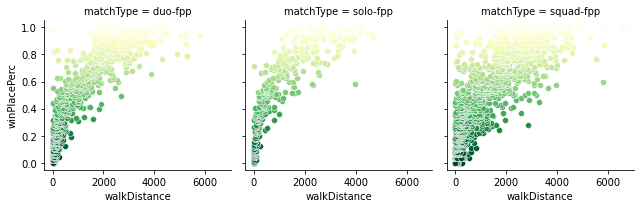

In [ ]:
# Comparing "winPlacePerc" by "matchType"
g = sns.FacetGrid(rankFPPMode.sample(2500), col = "matchType", hue = "winPlacePerc", palette = "YlGn_r")
g.map(sns.scatterplot, "walkDistance", "winPlacePerc")

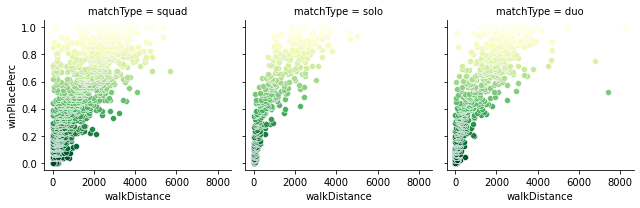

In [ ]:
g = sns.FacetGrid(rankTPPMode.sample(2500), col = "matchType", hue = "winPlacePerc", palette = "YlGn_r")
g.map(sns.scatterplot, "walkDistance", "winPlacePerc")

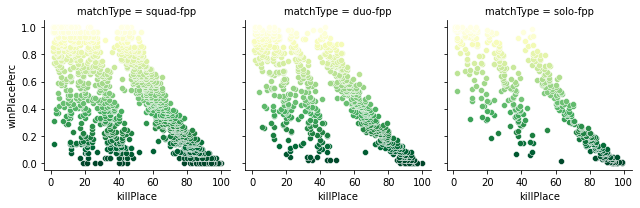

In [ ]:
g = sns.FacetGrid(rankFPPMode.sample(2500), col = "matchType", hue = "winPlacePerc", palette = "YlGn_r")
g.map(sns.scatterplot, "killPlace", "winPlacePerc")

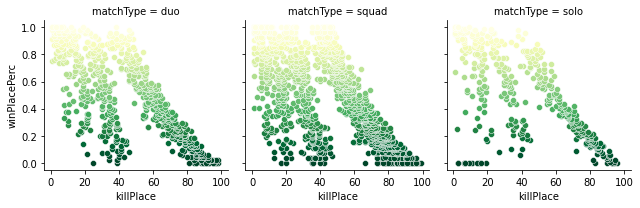

In [ ]:
g = sns.FacetGrid(rankTPPMode.sample(2500), col = "matchType", hue = "winPlacePerc", palette = "YlGn_r")
g.map(sns.scatterplot, "killPlace", "winPlacePerc")

## **EXCEPTIONAL WORK**
1. Setting up a Google colab file - this is a new tool for all of us.
2. Leveraging the Kaggle API to ingest the data directly from the Kaggle website to our Google collab, rather than needing to download the file and upload it from our local machine each time. 
3. Three correlation plots, each zooming in on a smaller slice of the data for additional analysis.
4. The above, nine visualizations broken down to investigate additional trends within the matchType variable: code section with comment #*Comparing "winPlacePerc" by "matchType"*
